# CMA/ES PER SUBJECT - 2 try: LL median

2/?

Trying LL median instead of LL here.
Also should try LL92 later if needed.

In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import os
import io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import progress

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import glob
import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

oldstdout = None

## Reload data

In [60]:
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/2try/

metric = 'dist_nll_median'
folder_pattern = "cmaes_subjects_bays09_ll92_2try_Mratiosigmaxsigmabaselinelapserate_subject*rep5_070118"
re_subject = re.compile(".*subject([0-9]*)rep")

df_all_fits = None

for filename in glob.glob("./%s/outputs/cmaes_alliter_tracking*.npy" % folder_pattern):
    found = re_subject.match(filename)
    subject = int(found.group(1))
    print "Reloading data of Subject %d" % subject
    
    curr_cmaes_trace = np.load(filename).item()

    candidates_parameters = np.array(curr_cmaes_trace['candidates'])
    fitness = np.array(curr_cmaes_trace['fitness'])
    parameter_names_sorted = curr_cmaes_trace['parameter_names_sorted']
    
    df_fits_subject = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                               ('experiment_subject', subject),
                                               (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                               [(param, candidates_parameters[:, param_i]) 
                                                    for param_i, param in enumerate(parameter_names_sorted)])
    
    if df_all_fits is None:
        df_all_fits = df_fits_subject
    else:
        df_all_fits = df_all_fits.append(df_fits_subject, ignore_index=True)
        
subject_space = np.sort(df_all_fits['experiment_subject'].unique())

parameter_names_sorted

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/2try
Reloading data of Subject 9
Reloading data of Subject 6
Reloading data of Subject 10
Reloading data of Subject 5
Reloading data of Subject 11
Reloading data of Subject 3
Reloading data of Subject 2
Reloading data of Subject 7
Reloading data of Subject 1
Reloading data of Subject 4
Reloading data of Subject 8
Reloading data of Subject 12


['M', 'lapse_rate', 'ratio_conj', 'sigma_baseline', 'sigmax']

In [61]:
# # Fix M and ratio_conj
# M_corrected, ratio_corrected = utils.fix_M_ratioconj(df_all_fits['M'], df_all_fits['ratio_conj'])
# df_all_fits.loc[:, 'M'] = M_corrected
# df_all_fits.loc[:, 'ratio_conj'] = ratio_corrected

In [62]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 20000
df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

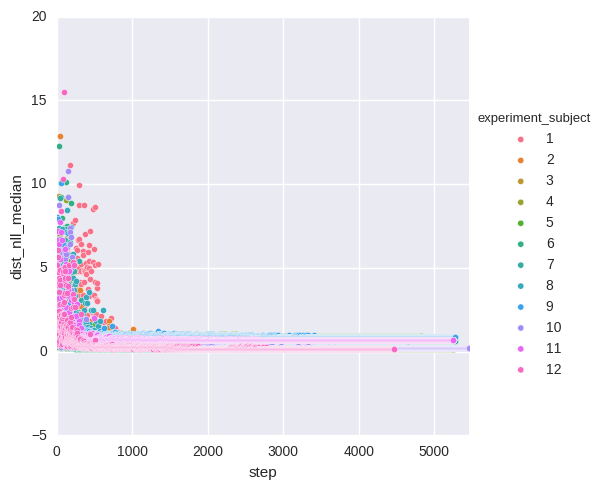

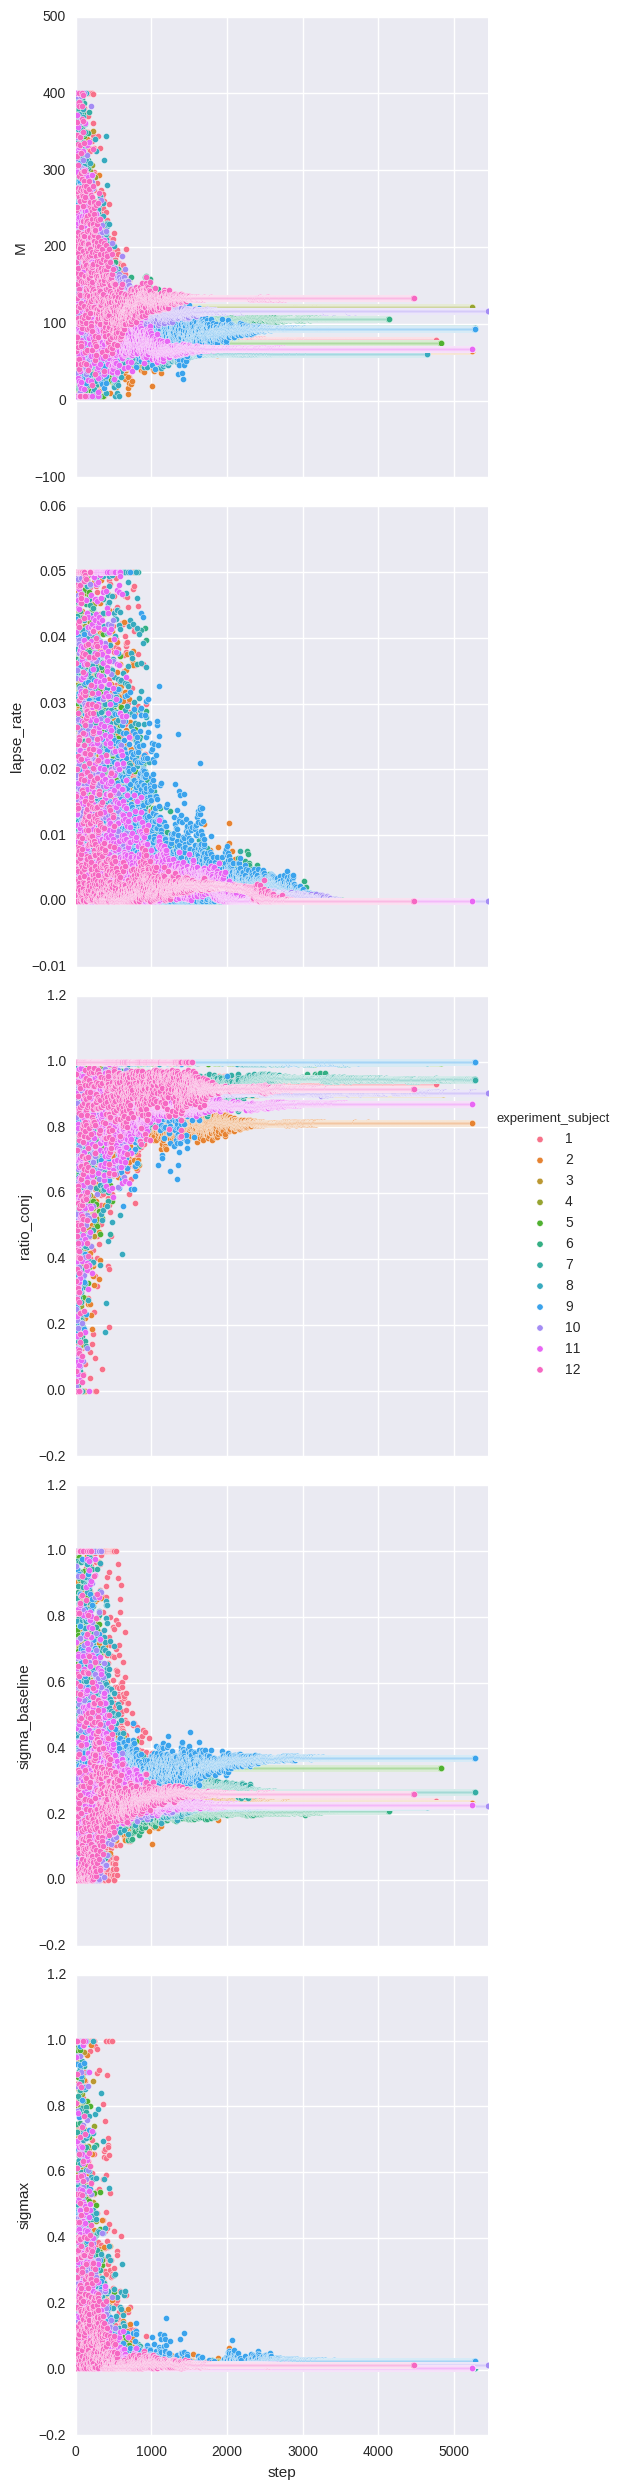

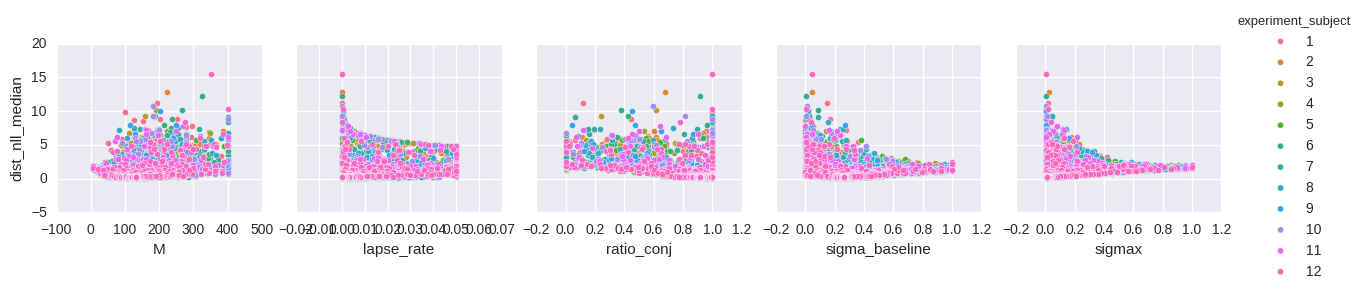

In [63]:
# Learning curve
g = sns.pairplot(df_best_fits,
                 y_vars=[metric],
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5,
                )

g.set(xlim=(-1, df_best_fits['step'].max())
)

# Check training of parameters
g = sns.pairplot(df_best_fits,
                 y_vars=parameter_names_sorted,
                 x_vars=['step'],
                 hue='experiment_subject',
                 size=5
                )
g.set(xlim=(-1, df_best_fits['step'].max()))

# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
             hue='experiment_subject',
            )


## Check parameters values obtained

In [64]:
df_bestparams_subjects = df_best_fits.groupby('experiment_subject').apply(
    lambda subDf: subDf.sort_values('step', ascending=False).head(120).median()
)
df_bestparams_subjects

,step,experiment_subject,dist_nll_median,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
experiment_subject,,,,,,,,
1,4709.5,1.0,0.633940,78.577468,1.410463e-11,0.930711,0.239182,0.005000
2,5189.5,2.0,0.671790,63.935735,5.620519e-13,0.812888,0.235078,0.013239
3,4799.5,3.0,0.398302,121.518289,2.568714e-13,0.902386,0.266662,0.017763
4,5189.5,4.0,0.135901,121.761565,7.660996e-14,0.997519,0.266919,0.007309
5,4769.5,5.0,0.932760,75.146813,5.912404e-14,0.996030,0.339894,0.005000
6,4079.5,6.0,0.132428,106.317670,1.137676e-07,0.999348,0.210868,0.013637
7,5219.5,7.0,0.615604,94.304168,2.285512e-13,0.945230,0.268146,0.005000
8,4589.5,8.0,0.639176,61.183628,2.223396e-13,0.994579,0.220760,0.005951
9,5219.5,9.0,0.889848,93.400054,3.042707e-11,0.999040,0.371059,0.027049


In [65]:
params_mean = df_bestparams_subjects.mean()
params_std = df_bestparams_subjects.std()

for param in parameter_names_sorted:
    print("%s   %.3g +- %.3g" % (param, params_mean[param], params_std[param]))

M   94.4 +- 25.3
lapse_rate   9.52e-09 +- 3.28e-08
ratio_conj   0.939 +- 0.0607
sigma_baseline   0.261 +- 0.0486
sigmax   0.0112 +- 0.0069


In [66]:
df_bestparams_subjects

,step,experiment_subject,dist_nll_median,M,lapse_rate,ratio_conj,sigma_baseline,sigmax
experiment_subject,,,,,,,,
1,4709.5,1.0,0.633940,78.577468,1.410463e-11,0.930711,0.239182,0.005000
2,5189.5,2.0,0.671790,63.935735,5.620519e-13,0.812888,0.235078,0.013239
3,4799.5,3.0,0.398302,121.518289,2.568714e-13,0.902386,0.266662,0.017763
4,5189.5,4.0,0.135901,121.761565,7.660996e-14,0.997519,0.266919,0.007309
5,4769.5,5.0,0.932760,75.146813,5.912404e-14,0.996030,0.339894,0.005000
6,4079.5,6.0,0.132428,106.317670,1.137676e-07,0.999348,0.210868,0.013637
7,5219.5,7.0,0.615604,94.304168,2.285512e-13,0.945230,0.268146,0.005000
8,4589.5,8.0,0.639176,61.183628,2.223396e-13,0.994579,0.220760,0.005951
9,5219.5,9.0,0.889848,93.400054,3.042707e-11,0.999040,0.371059,0.027049


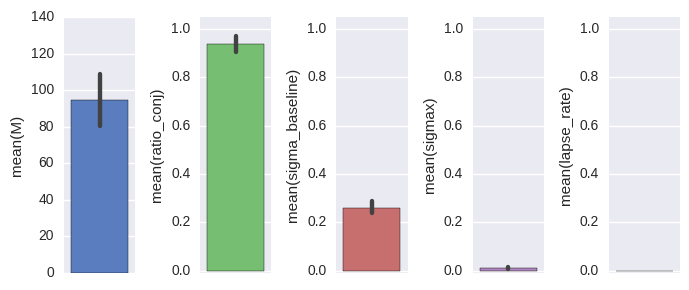

In [67]:
# df_best_params_meld = pd.melt(df_bestparams_subjects, id_vars=['experiment_subject', 'step', 'dist_nll'])
parameter_names_sorted = ['M', 'ratio_conj', 'sigma_baseline', 'sigmax', 'lapse_rate']
colors = sns.color_palette('muted', n_colors=5)
fig_parameters, axes = plt.subplots(1, 5, figsize=(7, 3))
axes = axes.flatten()
for i, param in enumerate(parameter_names_sorted):
    sns.barplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color=colors[i])
#     sns.swarmplot(df_bestparams_subjects[param], orient='v', ax=axes[i], color='#444444')

axes[0].set_ylim((-0.02, 140))
for ax in axes[1:]:
    ax.set_ylim((-0.01, 1.05))
fig_parameters.set_tight_layout(True)


## Get plots for all subjects, and associated EM fits

In [68]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_subject_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

all_results = dict()
all_plots_fit_exp = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "FitExperimentAllTSubject for subject %d" % subject

    experiment_parameters.update(df_bestparams_subjects.loc[subject])
    for key in ['M', 'experiment_subject']:
        experiment_parameters[key] = int(experiment_parameters[key])
    
    with io.capture_output() as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
        fit_exp = experiment_launcher.all_vars['fit_exp']
        all_results[subject] = experiment_launcher.all_vars['all_outputs_data']
        all_plots_fit_exp[subject] = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

[0%] --
FitExperimentAllTSubject for subject 1
[8%] 5m42s
FitExperimentAllTSubject for subject 2
[16%] 5m7s
FitExperimentAllTSubject for subject 3
[25%] 4m48s
FitExperimentAllTSubject for subject 4
[33%] 4m38s
FitExperimentAllTSubject for subject 5
[41%] 4m4s
FitExperimentAllTSubject for subject 6
[50%] 3m30s
FitExperimentAllTSubject for subject 7
[58%] 2m59s
FitExperimentAllTSubject for subject 8
[66%] 2m22s
FitExperimentAllTSubject for subject 9
[75%] 1m47s
FitExperimentAllTSubject for subject 10
[83%] 1m12s
FitExperimentAllTSubject for subject 11
[91%] 36s
FitExperimentAllTSubject for subject 12
[100%] 6m54s


[0%] --
Subject 1
[8%] 4s
Subject 2
[16%] 4s
Subject 3
[25%] 4s
Subject 4
[33%] 3s
Subject 5
[41%] 3s
Subject 6
[50%] 2s
Subject 7
[58%] 2s
Subject 8
[66%] 2s
Subject 9
[75%] 1s
Subject 10
[83%] 1s
Subject 11
[91%] 0s
Subject 12
[100%] 5s


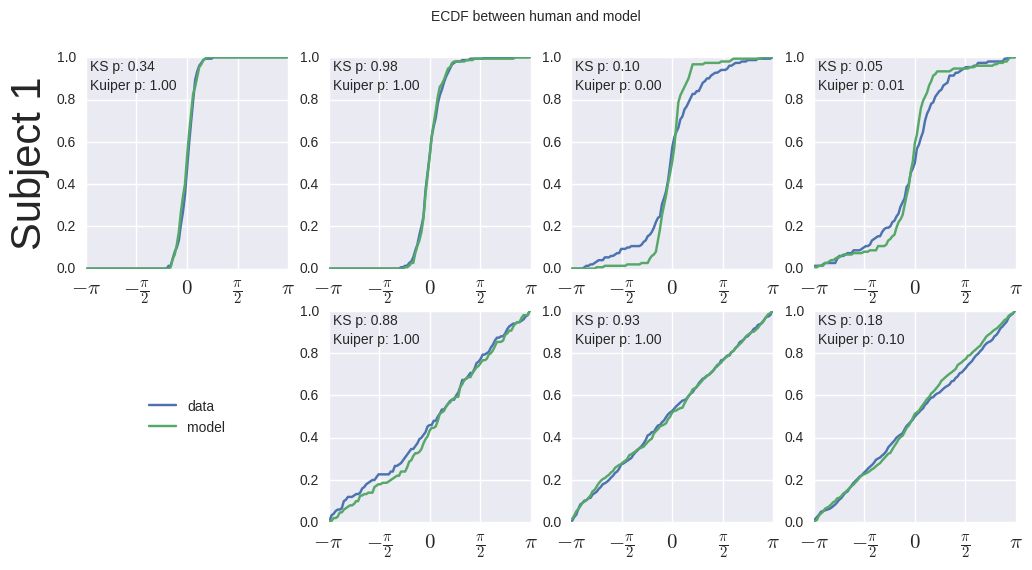

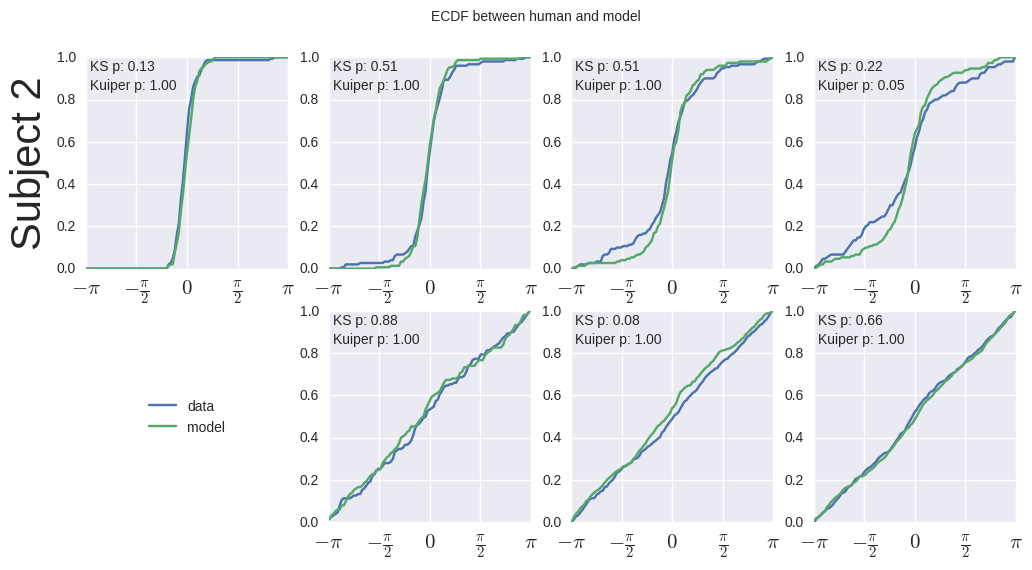

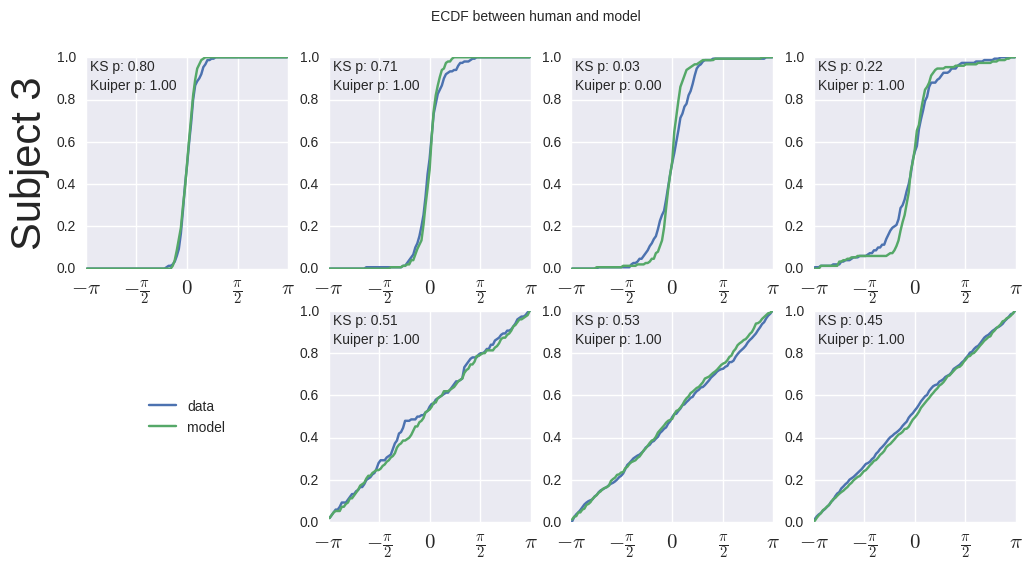

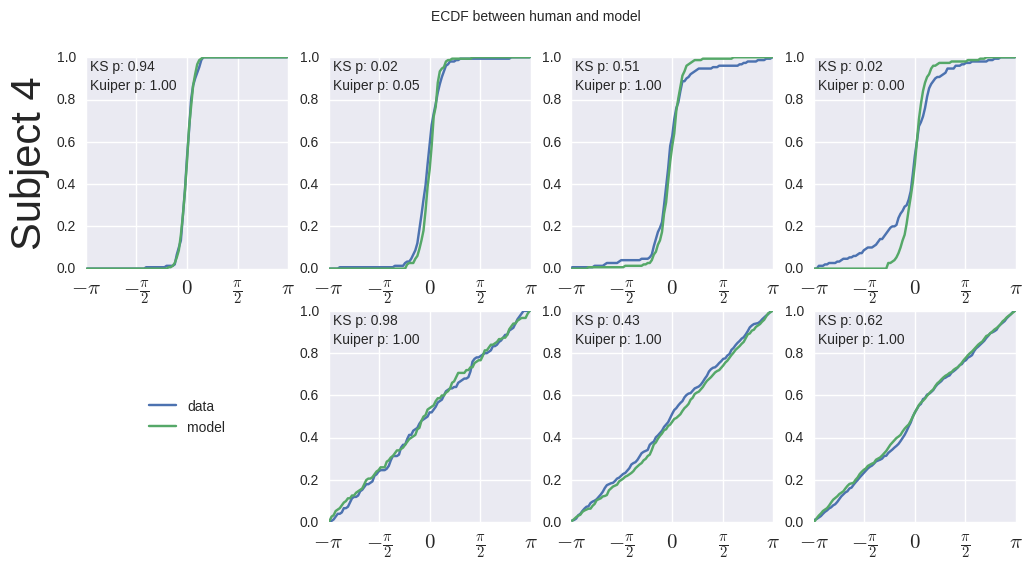

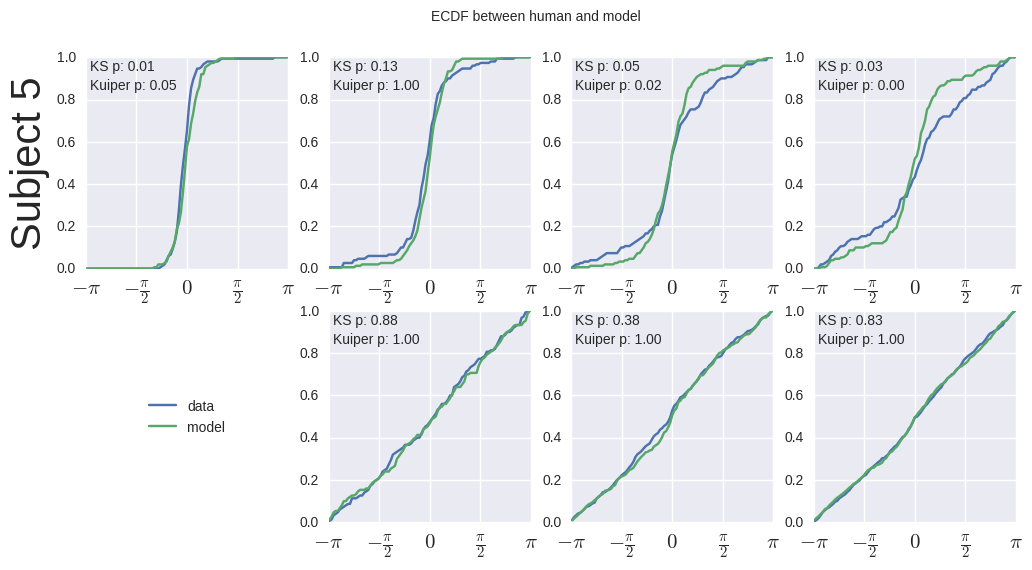

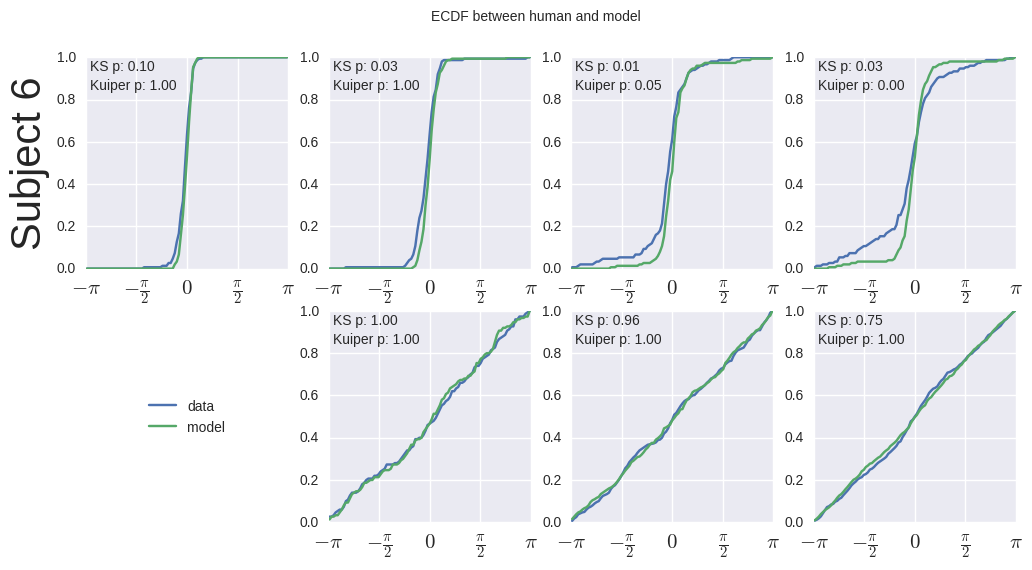

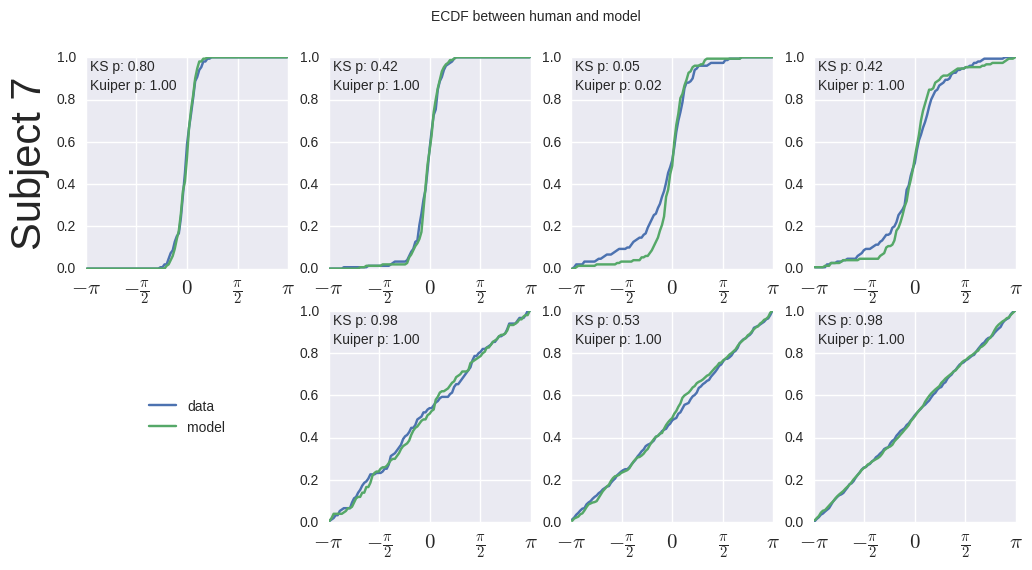

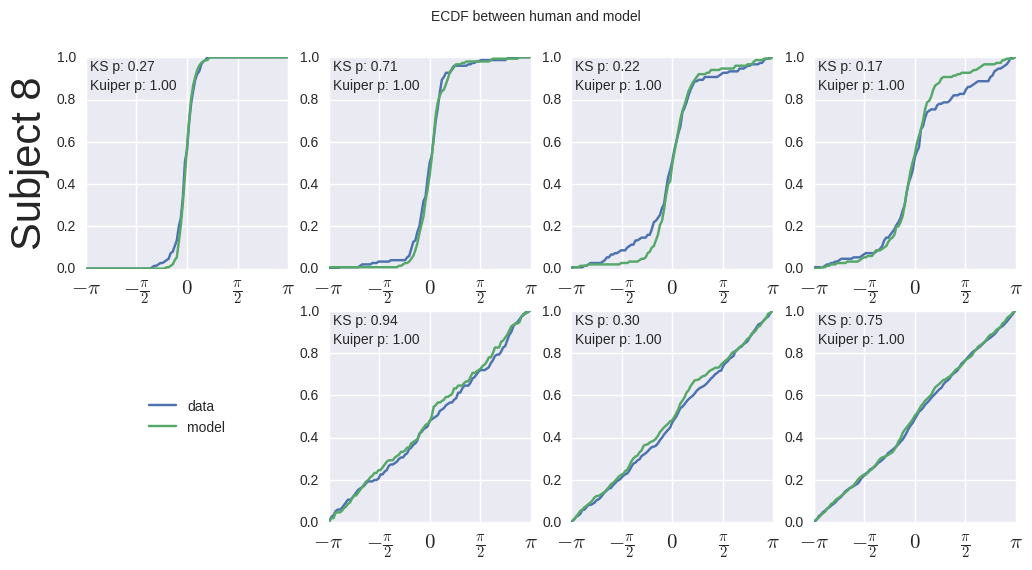

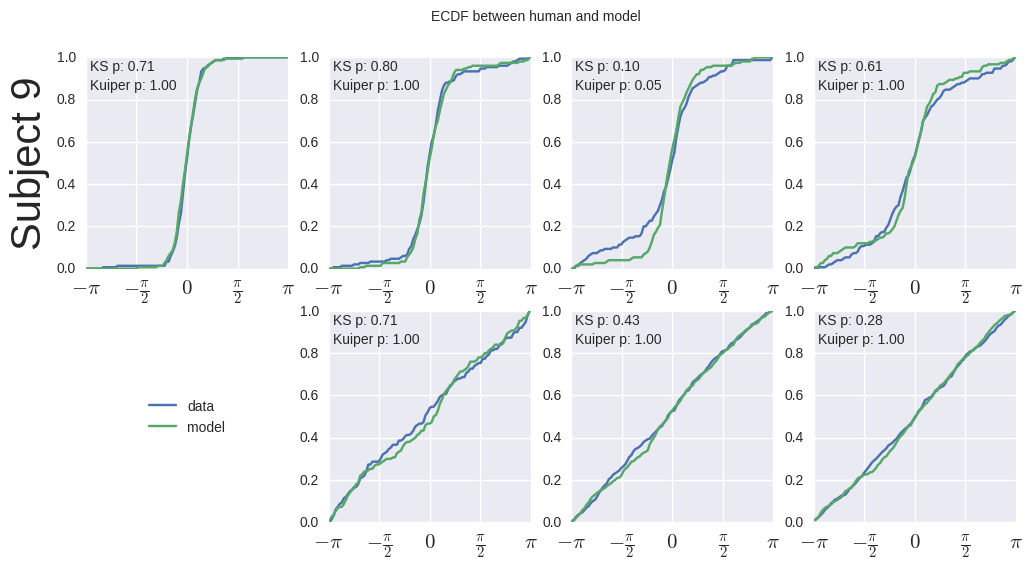

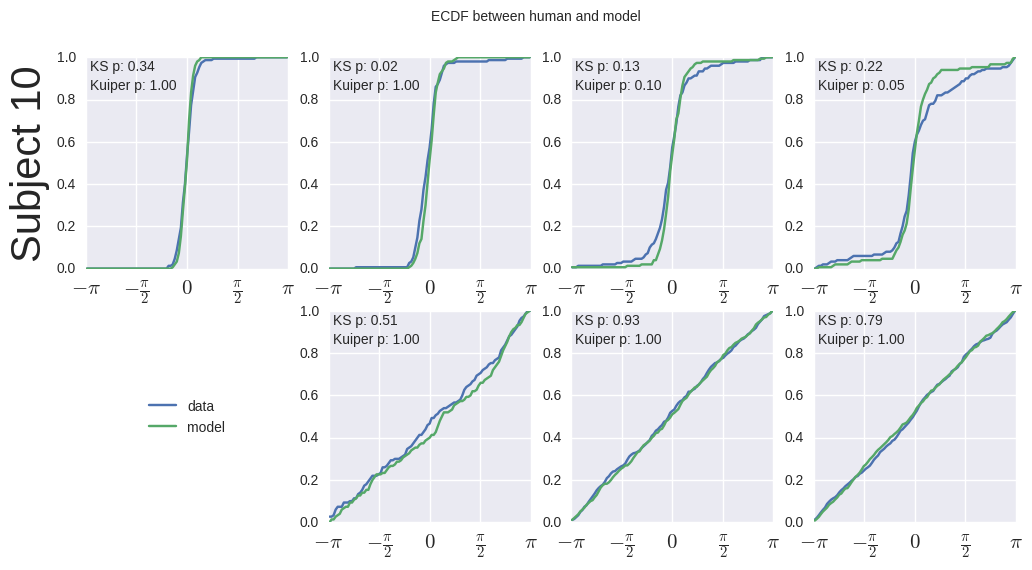

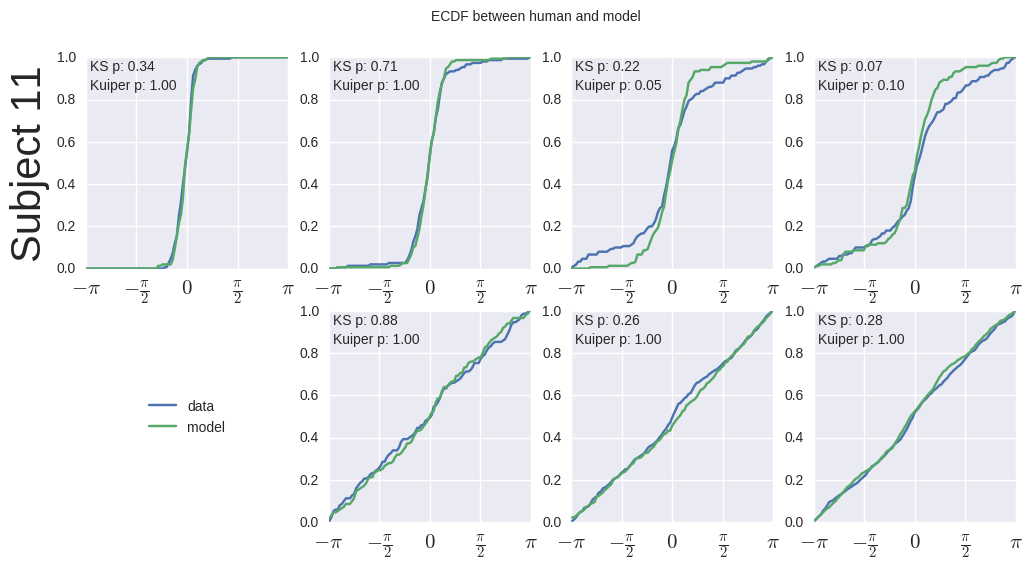

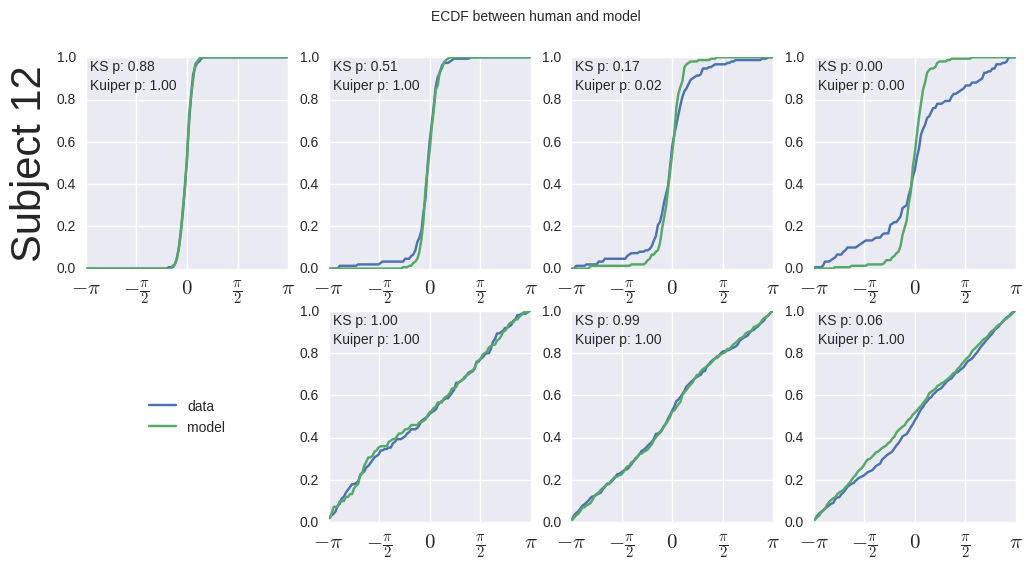

In [69]:
all_histogram_results = dict()

for subject in progress.ProgressDisplay(subject_space):
    print "Subject %d" % subject
    with io.capture_output(display=False, stderr=False) as captured:
        axes, all_histogram_results[subject] = all_plots_fit_exp[subject].plots_KS_comparison_fig2fig5(bins=100)
        axes[0, 0].set_ylabel('Subject %d' % subject, fontsize=30)


In [70]:
T_space = np.sort(all_histogram_results[subject]['kuiper_pval'].keys())

str_out = ""
for subject in progress.ProgressDisplay(subject_space):
    count_significant = 0
    str_out = str_out + "S:%3d | " % subject
    for condition in ['targets', 'nontargets']:
        for T, data in all_histogram_results[subject]['kuiper_pval'].iteritems():
            if condition in data:
                str_out = str_out + "%.3f " % data[condition]
                if data[condition] > 0.05:
                    count_significant += 1
        
        str_out = str_out + " | "
    
    str_out = str_out + " => %d good" % count_significant
    str_out = str_out + '\n'
print str_out

[0%] --
[8%] 0s
[16%] 0s
[25%] 0s
[33%] 0s
[41%] 0s
[50%] 0s
[58%] 0s
[66%] 0s
[75%] 0s
[83%] 0s
[91%] 0s
[100%] 0s
S:  1 | 1.000 1.000 0.001 0.010  | 1.000 1.000 0.100  |  => 5 good
S:  2 | 1.000 1.000 1.000 0.050  | 1.000 1.000 1.000  |  => 6 good
S:  3 | 1.000 1.000 0.001 1.000  | 1.000 1.000 1.000  |  => 6 good
S:  4 | 1.000 0.050 1.000 0.001  | 1.000 1.000 1.000  |  => 5 good
S:  5 | 0.050 1.000 0.020 0.002  | 1.000 1.000 1.000  |  => 4 good
S:  6 | 1.000 1.000 0.050 0.002  | 1.000 1.000 1.000  |  => 5 good
S:  7 | 1.000 1.000 0.020 1.000  | 1.000 1.000 1.000  |  => 6 good
S:  8 | 1.000 1.000 1.000 1.000  | 1.000 1.000 1.000  |  => 7 good
S:  9 | 1.000 1.000 0.050 1.000  | 1.000 1.000 1.000  |  => 6 good
S: 10 | 1.000 1.000 0.100 0.050  | 1.000 1.000 1.000  |  => 6 good
S: 11 | 1.000 1.000 0.050 0.100  | 1.000 1.000 1.000  |  => 6 good
S: 12 | 1.000 1.000 0.020 0.001  | 1.000 1.000 1.000  |  => 5 good



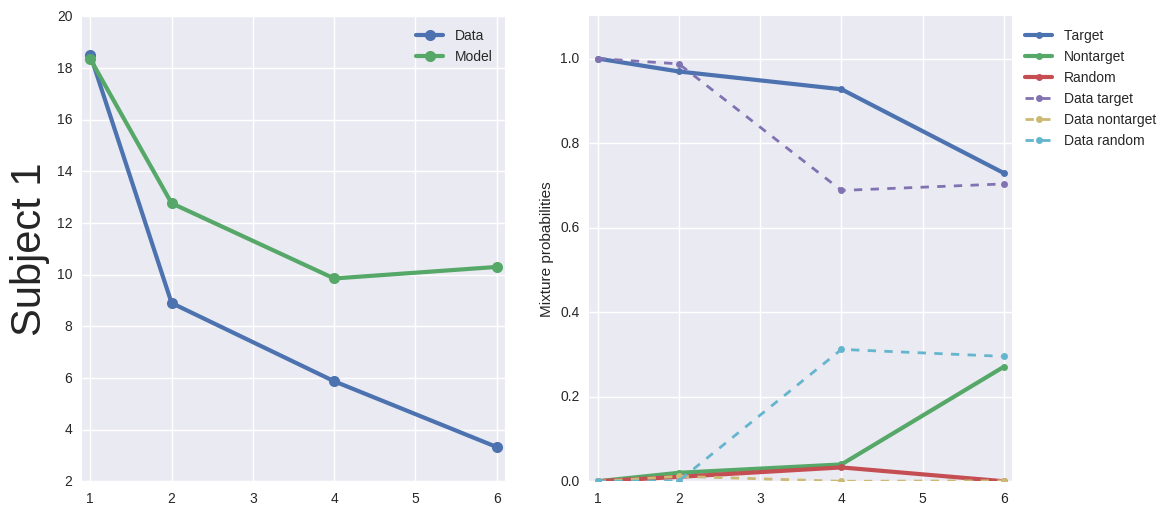

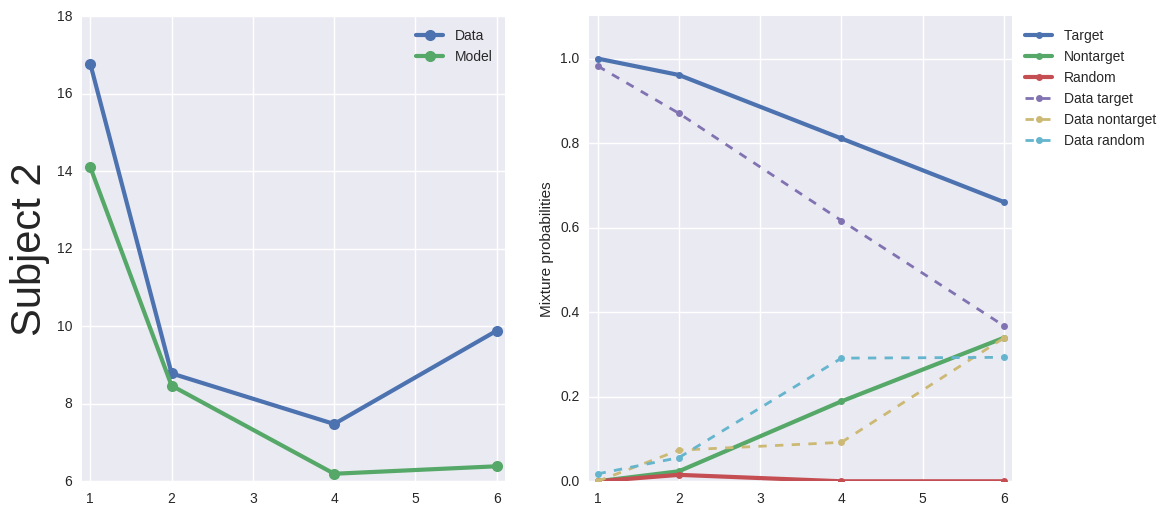

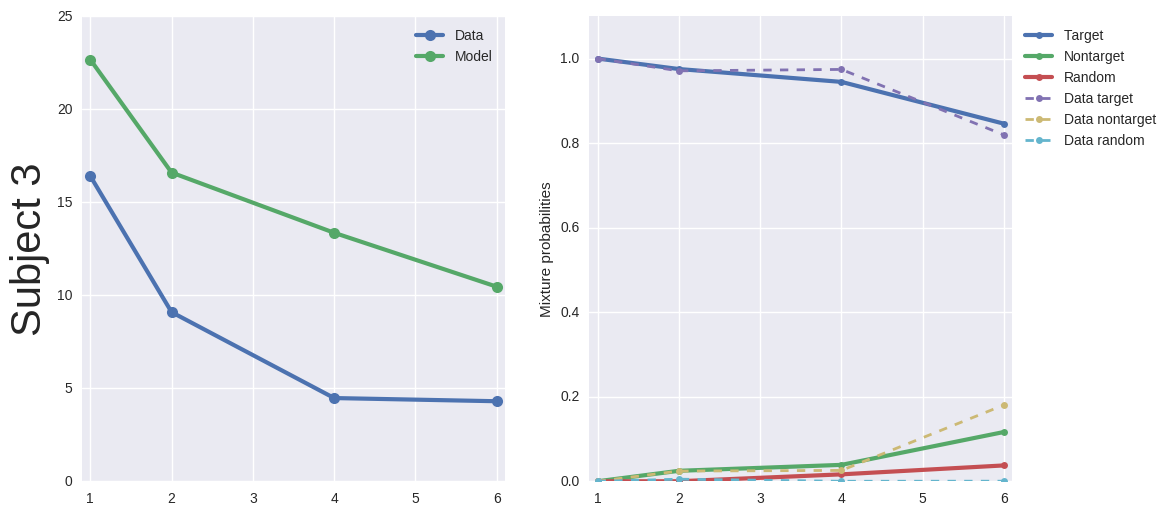

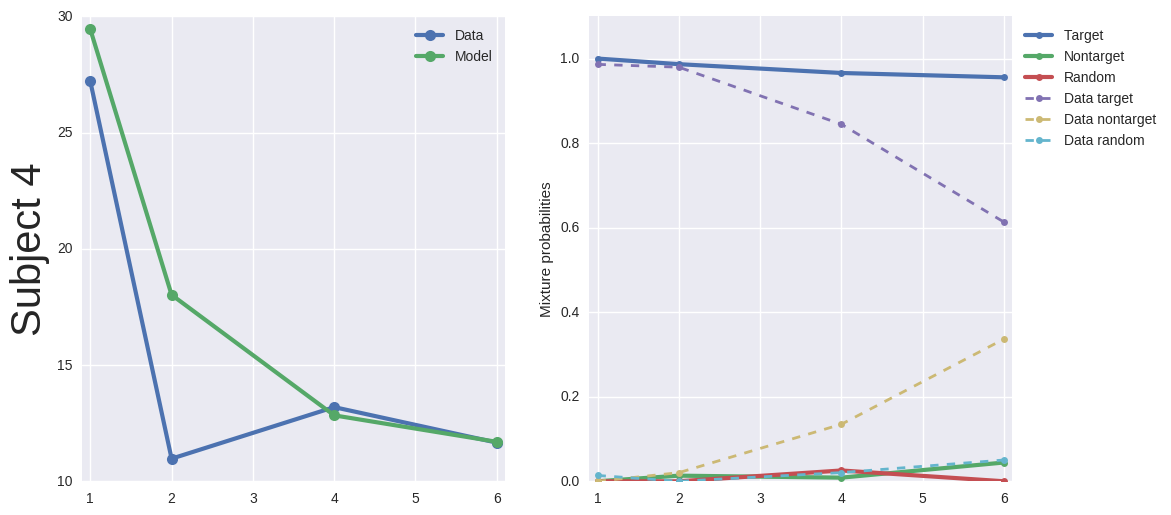

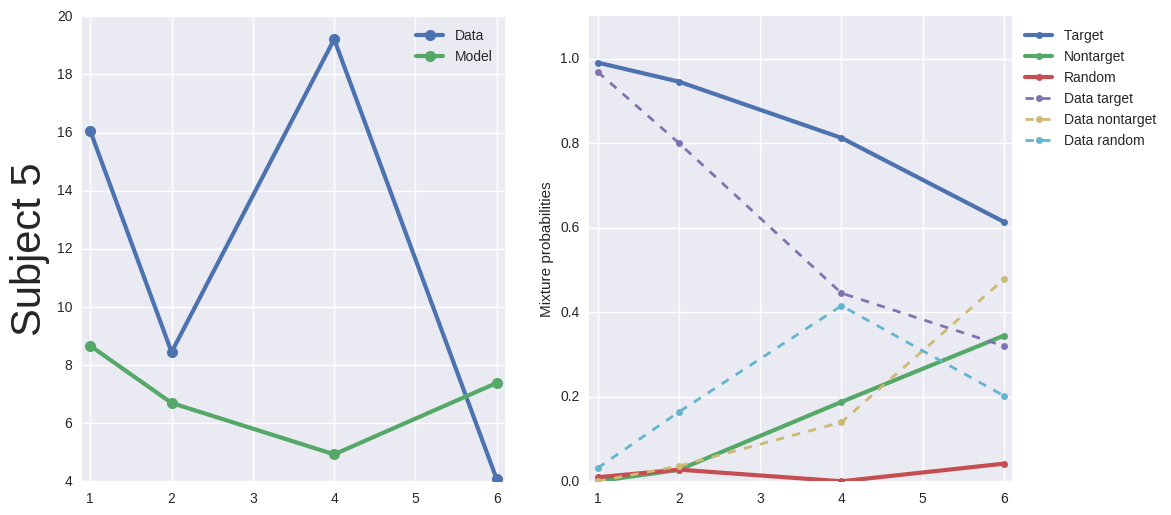

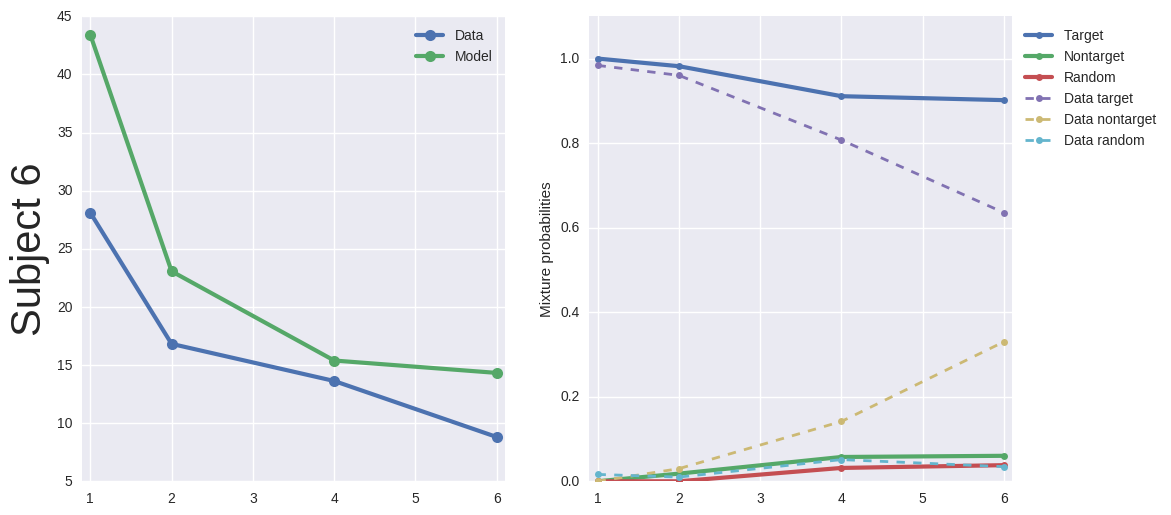

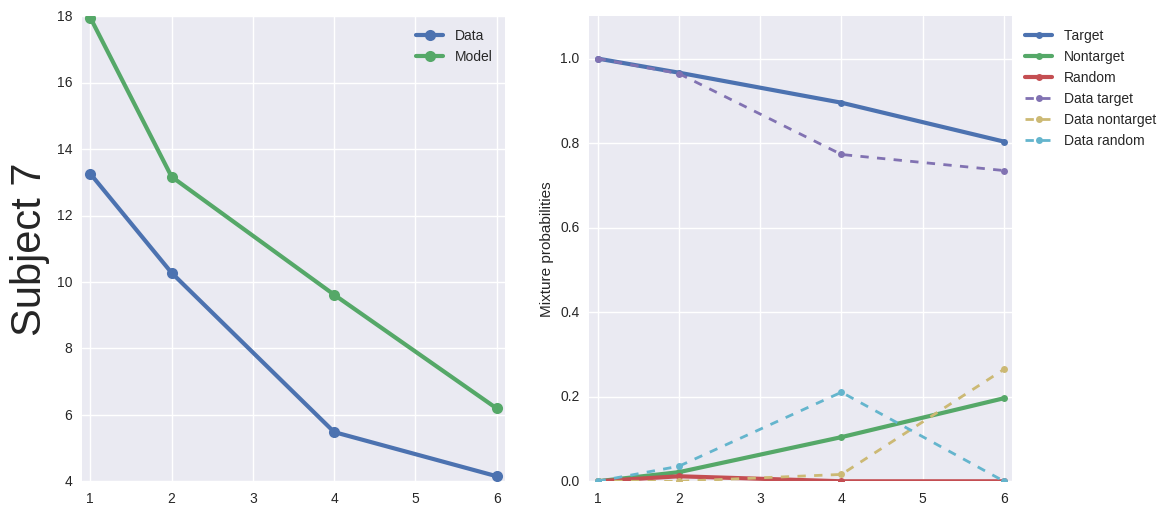

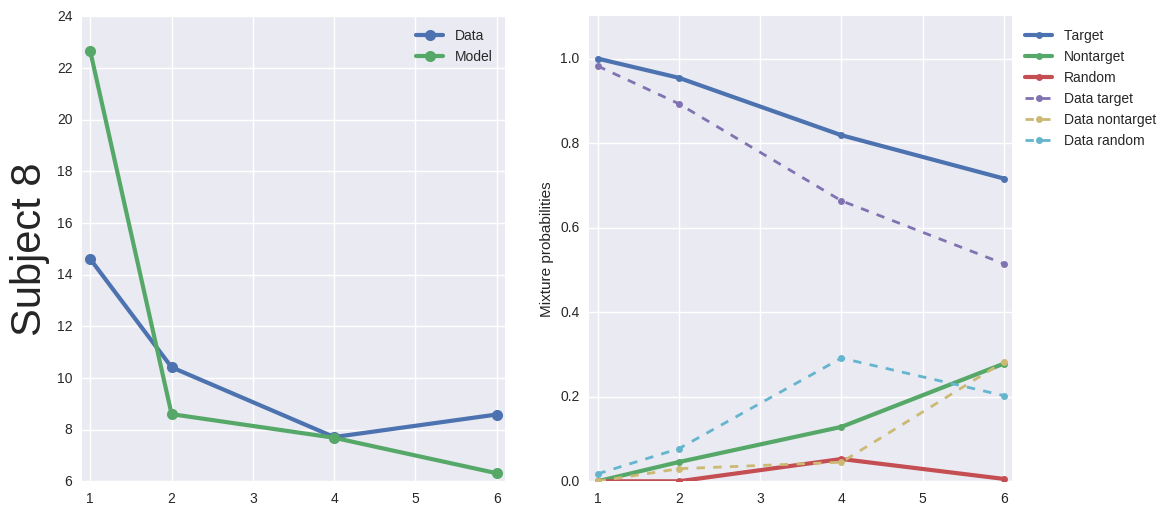

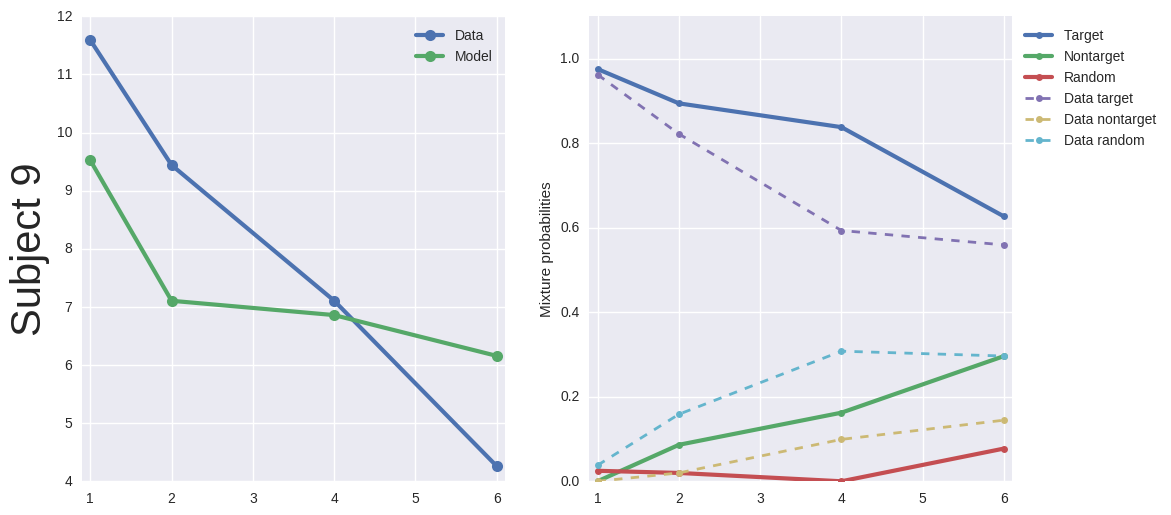

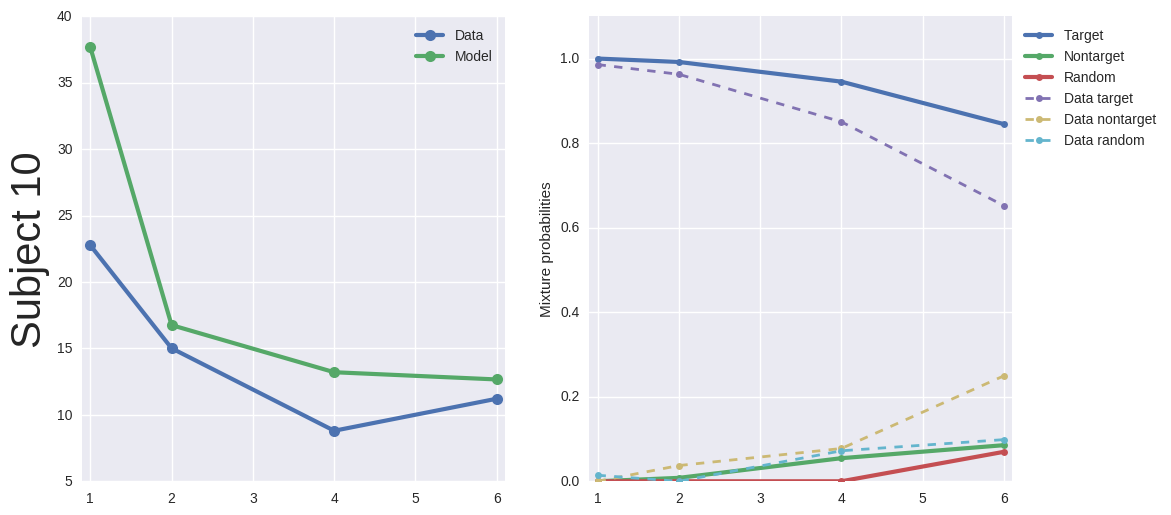

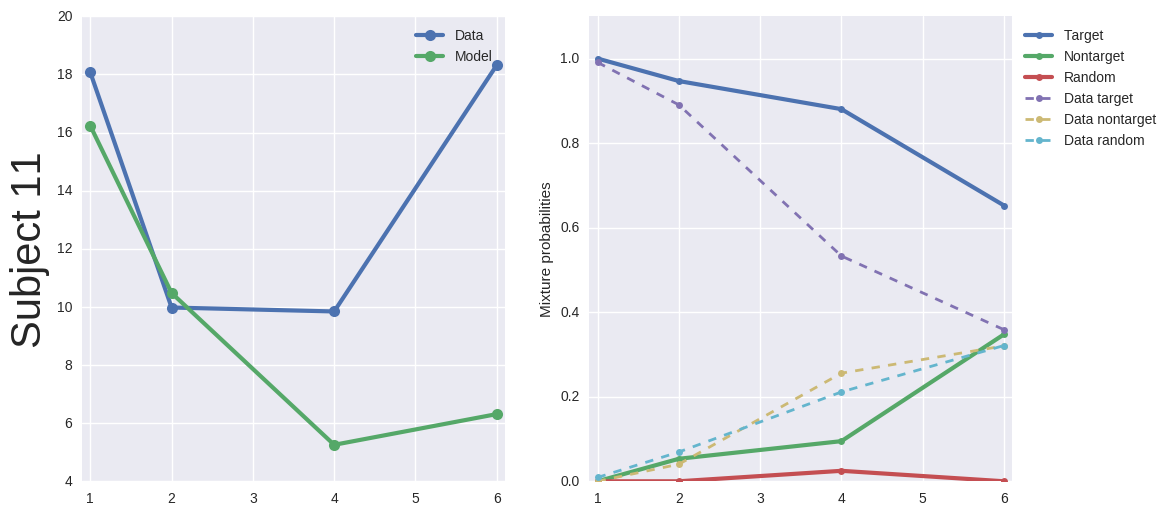

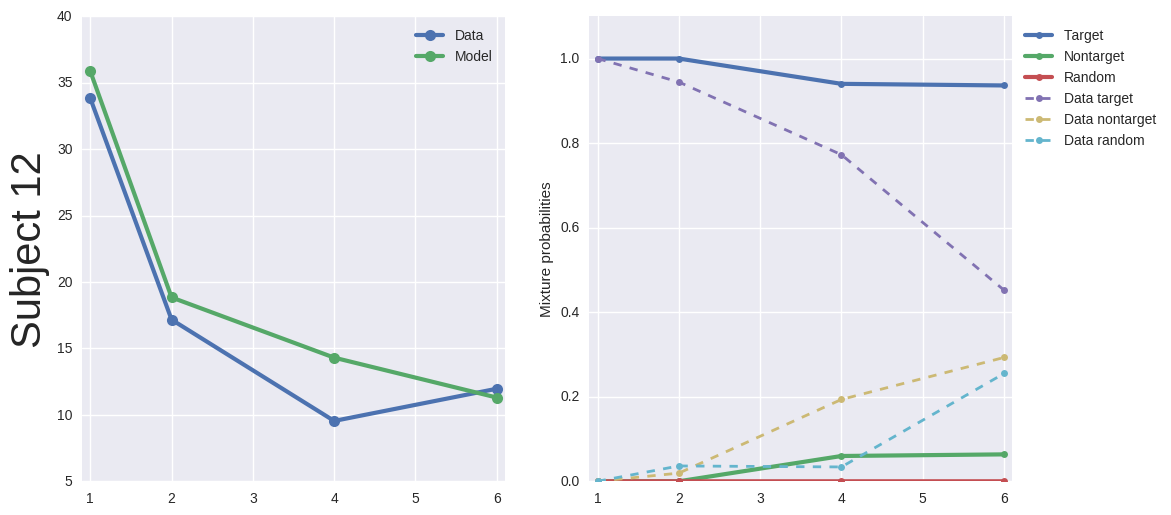

In [71]:
subj_fits_axes = dict()
with io.capture_output(display=False) as captured:
    for subject in subject_space:
        subj_fits_axes[subject] = all_plots_fit_exp[subject].plots_memmixtcurves_fig6fig13(num_repetitions=1, 
                                                                        use_cache=True, 
                                                                        layout='horizontal')
        subj_fits_axes[subject][0].set_ylabel('Subject %d' % subject, fontsize=30)
        subj_fits_axes[subject][0].set_title('')
        subj_fits_axes[subject][1].set_title('')
        subj_fits_axes[subject][0].set_xlabel('')
        subj_fits_axes[subject][1].set_xlabel('')

## Checking if average of parameters gives a good fit to the overall dataset

In [72]:
# Compute average parameter
df_avgparams_subjects = df_bestparams_subjects.mean()
df_avgparams_subjects

step                  4.897000e+03
experiment_subject    6.500000e+00
dist_nll_median       5.082836e-01
M                     9.444621e+01
lapse_rate            9.518292e-09
ratio_conj            9.393345e-01
sigma_baseline        2.613229e-01
sigmax                1.115973e-02
dtype: float64

In [73]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='sample',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=100,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             )

experiment_parameters.update(df_avgparams_subjects)
for key in ['M', 'experiment_subject']:
    experiment_parameters[key] = int(experiment_parameters[key])
    
experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
avgparam_fit_exp = experiment_launcher.all_vars['fit_exp']
avgparam_results = experiment_launcher.all_vars['all_outputs_data']
avgparam_plots_fit_exp = PlotsFitExperimentAllTPaperTheo(avgparam_fit_exp)


Arguments: ['-f', '/run/user/5201/jupyter/kernel-02b34ec6-f26c-44d1-ade9-42ac2a23df57.json']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'code_type': 'mixed', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 0.0, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normalise_weights': 1, 'use_theoretical_cov': False, 'best_parameters_file'

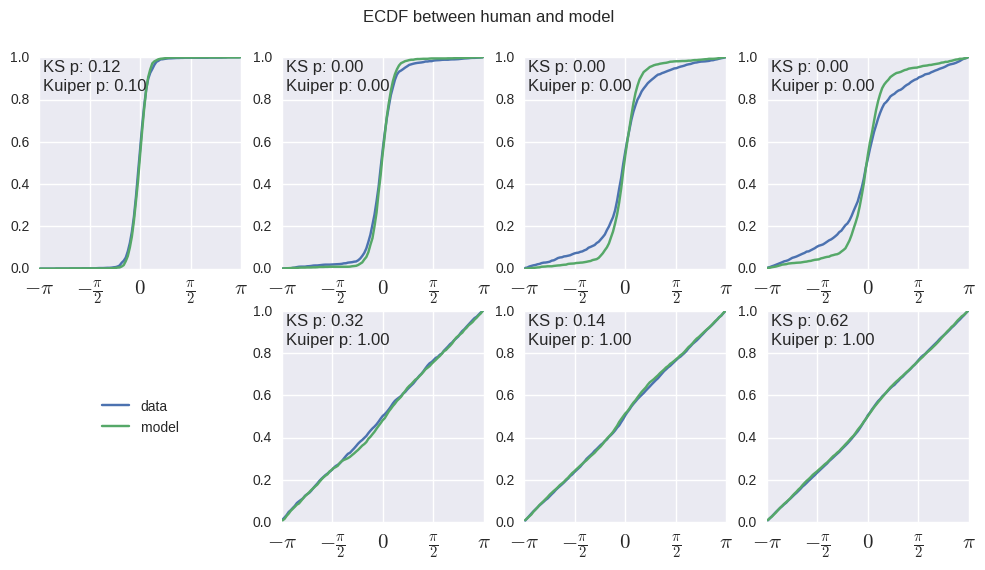

In [118]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)

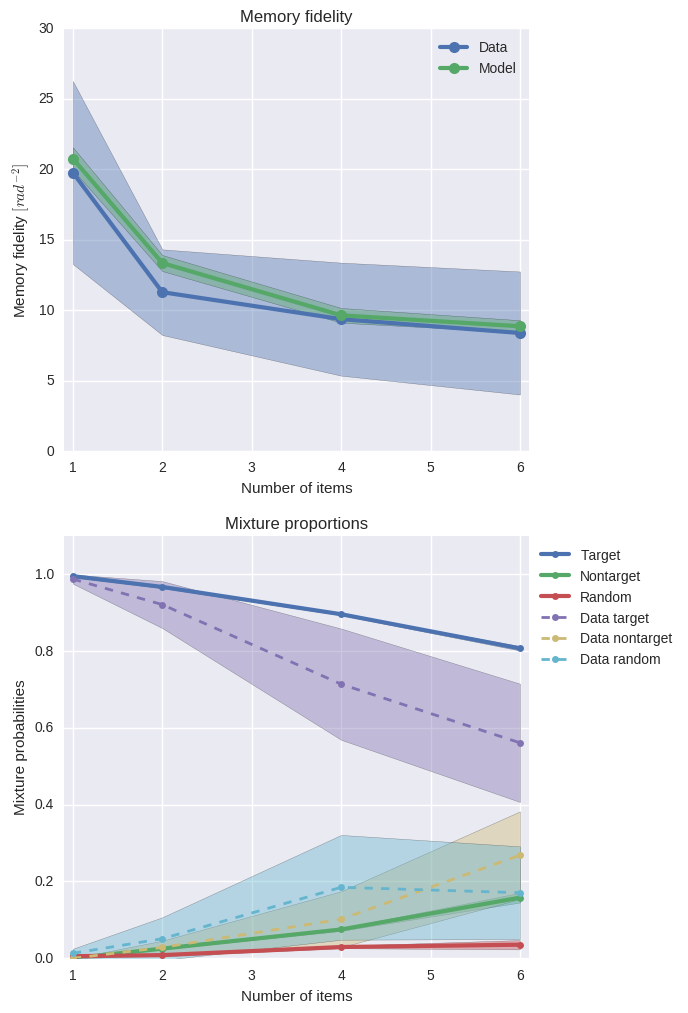

In [119]:
with io.capture_output(display=False) as captured:
    _ = avgparam_plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)

## Checking averaging the Subjects EM Fits

In [74]:
subjects_em_fits_list = []
for subject in subject_space:
    for T_i, T in enumerate(T_space):
        em_fits_subject = all_results[subject]['result_em_fits'].squeeze()
        subjects_em_fits_list.append(
            dict(subject=subject,
                 T=T,
                 em_kappa=em_fits_subject[T_i, 0],
                 em_target=em_fits_subject[T_i, 1],
                 em_nontarget=em_fits_subject[T_i, 2],
                 em_random=em_fits_subject[T_i, 3],
                 em_ll=em_fits_subject[T_i, 4],
                 em_bic=em_fits_subject[T_i, 5],
                 model_bic=all_results[subject]['result_bic'].squeeze()[T_i],
                 model_ll=all_results[subject]['result_ll_sum'].squeeze()[T_i]
                )
            )

subjects_em_fits_df = pd.DataFrame(subjects_em_fits_list)
subjects_em_fits_df

,T,em_bic,em_kappa,em_ll,em_nontarget,em_random,em_target,model_bic,model_ll,subject
0,1,13.953696,18.346390,3.044423,0.000000e+00,5.279663e-09,1.000000,248.218455,-114.087957,1
1,2,106.975469,12.763409,-43.466464,2.012032e-02,1.049482e-02,0.969385,385.957177,-182.957318,1
2,4,192.141206,9.850277,-86.049332,3.984776e-02,3.278421e-02,0.927368,719.143665,-349.550562,1
3,6,292.243140,10.297693,-136.100299,2.711667e-01,3.249236e-07,0.728833,748.657368,-364.307414,1
4,1,55.273236,14.105244,-17.615347,0.000000e+00,9.495433e-08,1.000000,424.855297,-202.406378,2
5,2,175.070325,8.467643,-77.513892,2.364400e-02,1.519620e-02,0.961160,467.702387,-223.829923,2
6,4,308.506124,6.194167,-144.231792,1.891254e-01,5.357249e-07,0.810874,646.093268,-313.025364,2
7,6,386.726900,6.387043,-183.342179,3.395435e-01,1.943761e-05,0.660437,679.460692,-329.709076,2
8,1,-16.255221,22.672651,18.148881,0.000000e+00,3.967407e-09,1.000000,386.912841,-183.435150,3
9,2,55.435581,16.597114,-17.696520,2.477037e-02,4.061358e-05,0.975189,472.217945,-226.087702,3


In [75]:
# This computes the average fits across subjects. Exactly same as Fig 6!
subjects_pivot = subjects_em_fits_df[['em_kappa', 'em_target', 'em_nontarget', 'em_random', 'T']].groupby('T')

subjectsavg_emfit = dict(
    mean=subjects_pivot.mean().as_matrix(),
    std=subjects_pivot.std().as_matrix()
)

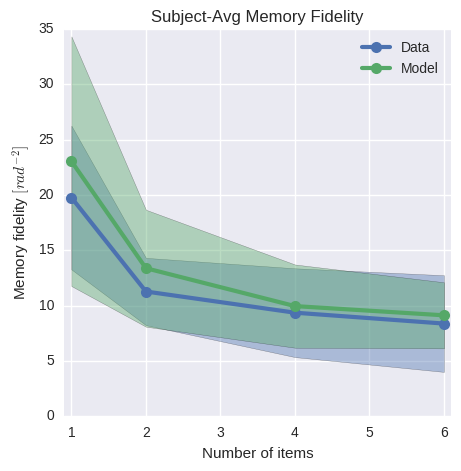

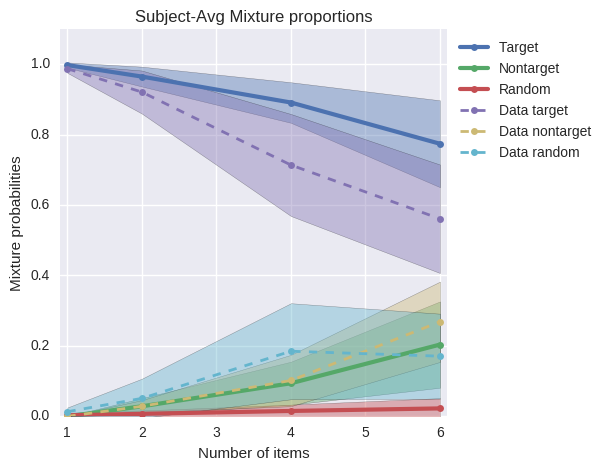

In [79]:
subj_avgfit_memfid = avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_memcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Memory Fidelity")
subj_avgfit_memfid.figure.set_size_inches((5, 5))
subj_avgfit_mixtprop = avgparam_plots_fit_exp._PlotsFitExperimentAllTPaperTheo__plot_mixtcurves(subjectsavg_emfit, suptitle_text="Subject-Avg Mixture proportions")
subj_avgfit_mixtprop.figure.set_size_inches((5, 5))

# Fits are totally ok.

Let's output the per-subject Mixture fits, the parameter values obtained, and the overall average fits.

In [55]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_subject_bays09_llmedian', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_subject_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/2try/outputs/thesis_subject_bays09_llmedian-3d1ebdca-304f-44c6-8e77-6ec3b01487cd ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/2try/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_2try
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_subject_cmaes_08_2016/2try/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_subject_cmaes_08_2016/fitexperiment_subject_cmaes_08_2016_2try


In [142]:
# Subject-Avg fits
subj_avgfit_memfid.figure.savefig(dataio.create_formatted_filename("subjectavg_memfidelity_{label}_{unique_id}.pdf"))
subj_avgfit_mixtprop.figure.savefig(dataio.create_formatted_filename("subjectavg_mixtprop_{label}_{unique_id}.pdf"))

In [146]:
# Subjects fits
for subj, sub_axes in subj_fits_axes.iteritems():
    sub_axes[0].figure.savefig(dataio.create_formatted_filename("subject_%d_emfits_{label}_{unique_id}.pdf" % subj))

In [56]:
# Parameters
fig_parameters.savefig(dataio.create_formatted_filename("barplot_params_{label}_{unique_id}.pdf"))